# Doublet Detection on 8k PBMCs from 10x Genomics

In [1]:
import numpy as np
# Ignore warning for convergence plot
np.warnings.filterwarnings('ignore')
import pandas as pd
import sys
import doubletdetection
import tarfile
import time
from bhtsne import tsne
from sklearn.decomposition import PCA
import phenograph
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Download Data from 10x

In [2]:
!wget http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
tar = tarfile.open('pbmc8k_filtered_gene_bc_matrices.tar.gz')
tar.extractall()
tar.close()

--2018-04-11 18:11:21--  http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 13.33.35.71, 13.33.35.175, 13.33.35.13, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|13.33.35.71|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37558165 (36M) [application/x-tar]
Saving to: ‘pbmc8k_filtered_gene_bc_matrices.tar.gz’

pbmc8k_filtered_gen 100%[===================>]  35.82M  6.58MB/s    in 5.6s    

2018-04-11 18:11:27 (6.44 MB/s) - ‘pbmc8k_filtered_gene_bc_matrices.tar.gz’ saved [37558165/37558165]



### Make Count Matrix

This function converts a 10x count matrix into a simply numpy array

In [3]:
def read_from_mtx(folder):
    import scipy.io
    from scipy.io import mmread
    bcl = []
    with open(folder + "barcodes.tsv") as f1:
        for line in f1:
            bcl.append(line.strip())
    gl = []
    with open(folder + "genes.tsv") as f2:
        for line in f2:
            arr = line.strip().split('\t')
            gl.append(arr[1].rstrip())

    gcm = np.transpose(mmread(folder + "matrix.mtx").toarray())
    return gcm, np.array(bcl), np.array(gl)

In [4]:
root = 'filtered_gene_bc_matrices/GRCh38/'
raw_counts, barcodes, genes = read_from_mtx(root)
# Remove columns with all 0s
zero_genes = np.sum(raw_counts, axis=0) == 0
raw_counts = raw_counts[:, ~zero_genes]
genes = genes[~zero_genes]

## Run Doublet Detection

Right now, phenograph is a bit talkative, so we capture the output to avoid lots of text

In [5]:
%%capture

clf = doubletdetection.BoostClassifier(n_iters=25)

start = time.time()
doublets = clf.fit(raw_counts).predict()
end = time.time()

In [6]:
print('Time elapsed: {} seconds for 25 iterations'.format(np.round(end-start, 2)))

Time elapsed: 576.83 seconds for 25 iterations


## Visualize Results

### Convergence of Doublet Calls

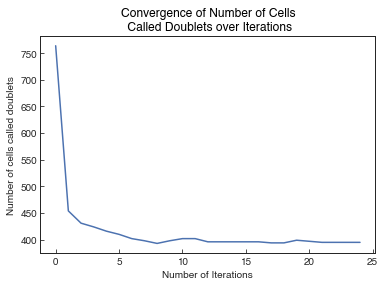

In [7]:
doubletdetection.plot.convergence(clf)

### Doublets on TSNE map

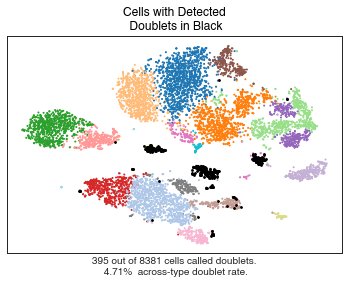

In [8]:
doubletdetection.plot.tsne(raw_counts, doublets)